# Introduction


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import torch
from transformers import BertTokenizer, BertModel
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Libraries



In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Unzippig Data

In [ ]:
print("Unzipping the data...")
!unzip -q OLIDv1.0.zip -d ./olid_data

Unzipping the data...


#Loading the DataSet and Reading the Data

In [ ]:
import pandas as pd

df = pd.read_csv("/content/olid_data/olid-training-v1.0.tsv", sep="\t")
print(df.head())

      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#IsNull

In [ ]:
print("\nNull counts:")
print(df.isnull().sum())
print("\nSubtask A labels:\n", df['subtask_a'].value_counts())
print("Subtask B labels:\n", df['subtask_b'].value_counts())#TIN = Targeted Insult,UNT=Untargeted
print("Subtask C labels:\n", df['subtask_c'].value_counts())


Null counts:
id              0
tweet           0
subtask_a       0
subtask_b    8840
subtask_c    9364
dtype: int64

Subtask A labels:
 subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64
Subtask B labels:
 subtask_b
TIN    3876
UNT     524
Name: count, dtype: int64
Subtask C labels:
 subtask_c
IND    2407
GRP    1074
OTH     395
Name: count, dtype: int64


# Here we are preprocessing the data and cleaning up deal with nulls

In [ ]:
# Step 3: Preprocessing—clean it up, deal with nulls
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Defining preprocess_tweet and clean the tweets which helps to understand the correct meaning of the tweet

In [ ]:
def preprocess_tweet(tweet):
    """Clean the tweet, handle nulls, keep some punctuation for vibe."""
    if pd.isnull(tweet):  # If it’s NaN, just give a blank string
        return ""
    tweet = str(tweet).lower()  # Make sure it’s a string, lowercase it
    tweet = re.sub(r'@user', '', tweet)  # No @USER clutter
    tweet = re.sub(r'http\S+|www.\S+', '', tweet)  # URLs? Outta here
    tweet = re.sub(r'([!?])\1+', r'\1', tweet)  # !!!! → !

    tokens = word_tokenize(tweet)
    clean_tokens = []
    for tok in tokens:
        # Keep letters and ! or ?, skip the rest
        if not tok.isalpha() and tok not in ['!', '?']:
            continue
        if tok in stop_words and tok not in ['not', 'no']:  # Keep negation
            continue
        clean_tokens.append(lemmatizer.lemmatize(tok))

    return " ".join(clean_tokens) if clean_tokens else ""  # Empty if no tokens

In [ ]:
print("\nCleaning up the tweets...")
df['clean_tweet'] = df['tweet'].apply(preprocess_tweet)


Cleaning up the tweets...


#cleaned tweets

In [ ]:
print(df)

          id                                              tweet subtask_a  \
0      86426  @USER She should ask a few native Americans wh...       OFF   
1      90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   
...      ...                                                ...       ...   
13235  95338  @USER Sometimes I get strong vibes from people...       OFF   
13236  67210  Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...       NOT   
13237  82921  @USER And why report this garbage.  We don't g...       OFF   
13238  27429                                        @USER Pussy       OFF   
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT   

      subtask_b subtask_c                                        clean_twee

# Feature Extraction—BERT vs. TF-IDF showdown

In [ ]:
# Step 4: Feature Extraction—BERT vs. TF-IDF showdown
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_bert_embeddings(texts):
    """Grab BERT embeddings—takes time, but it’s worth it."""
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).numpy().flatten())
    return np.array(embeddings)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=6000)  # Upped features a bit

In [ ]:
print("\nTF-IDF features...")
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_tweet'])
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF features...
TF-IDF shape: (13240, 6000)


In [ ]:
print(X_tfidf)

  (0, 339)	0.4004056181940148
  (0, 3480)	0.5402243212914455
  (0, 169)	0.3363076384025168
  (0, 5192)	0.3163166660299901
  (0, 3481)	0.578510123288832
  (1, 2148)	0.296399722028548
  (1, 2426)	0.39255678616337747
  (1, 1558)	0.4832159501345192
  (1, 3157)	0.23972682795132744
  (1, 5616)	0.19591631018919262
  (1, 2157)	0.5470511292640617
  (1, 3177)	0.3597660757870804
  (2, 3157)	0.11723080314546958
  (2, 5616)	0.09580665872506831
  (2, 160)	0.5803262670064988
  (2, 893)	0.2565254551358366
  (2, 1643)	0.2542714572197173
  (2, 4733)	0.2565254551358366
  (2, 1278)	0.25018237587967435
  (2, 3098)	0.191967447763004
  (2, 1600)	0.279170581608672
  (2, 999)	0.284206686116436
  (2, 2670)	0.20169110185016312
  (2, 892)	0.23758277813369522
  (2, 5229)	0.21008876836267332
  :	:
  (13234, 4504)	0.46144058126658666
  (13234, 1959)	0.5021748636283403
  (13235, 3982)	0.1398237594978804
  (13235, 2090)	0.14646123654441384
  (13235, 3445)	0.24415217765582153
  (13235, 3210)	0.18521691466316714
  (1323

In [ ]:
#print("Now for BERT—hold tight, this’ll take a sec...")
print("BERT working ")
X_bert = get_bert_embeddings(df['clean_tweet'])
print("BERT shape:", X_bert.shape)


Now for BERT—hold tight, this’ll take a sec...
BERT shape: (13240, 768)


In [ ]:
print(X_bert)

[[ 0.24657845  0.16218264 -0.54695874 ... -0.09708053 -0.3977275
  -0.06054431]
 [ 0.00220668  0.15251693  0.7082937  ... -0.3686969   0.01280844
  -0.01359813]
 [-0.07967153 -0.00253218  0.14770968 ... -0.20086205  0.10606516
   0.01358666]
 ...
 [ 0.6392501   0.30446368 -0.094637   ...  0.00206338 -0.00746425
  -0.27336672]
 [ 0.21830411 -0.13062496 -0.04505285 ... -0.01969313 -0.18233995
  -0.17299794]
 [ 0.10119918 -0.11294637  0.44421545 ... -0.4735723  -0.01756887
  -0.2546939 ]]


# Word cloud map


Making a word cloud...


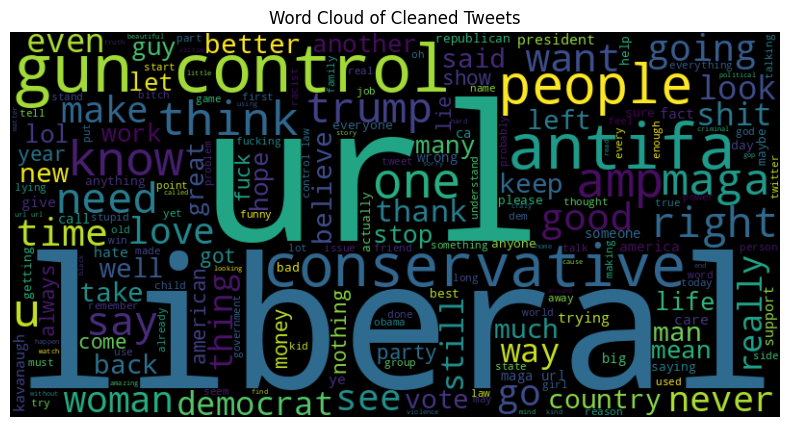

In [ ]:
# Step 5: Word Cloud—let’s see what’s popping
print("\nWorking on word cloud...")
all_text = " ".join(df['clean_tweet'])
wordcloud = WordCloud(width=900, height=450, background_color='black', max_words=300).generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Cleaned Tweets")
plt.show()

In [ ]:
y_a = df['subtask_a']

# **Defining Confusion Matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Quick confusion matrix plot."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# **Train Function**

In [ ]:
def train_and_compare(X, y, subtask_name, is_bert=False):
    """Test models, pick the best, note if it’s BERT."""
    models = {
        "LogisticRegression": {
            "model": LogisticRegression(solver='liblinear', max_iter=3000, random_state=42, class_weight='balanced'),
            "params": {"clf__C": [0.1, 1, 10]}
        },
        "SVM": {
            "model": SVC(random_state=42, class_weight='balanced'),
            "params": {"clf__C": [1, 10], "clf__kernel": ["linear"]}
        },
        "RandomForest": {
            "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
            "params": {"clf__n_estimators": [100, 200], "clf__max_depth": [10, None]}
        },
        "NaiveBayes": {
            "model": MultinomialNB(),
            "params": {"clf__alpha": [0.1, 1]}
        }
    }

    best_model = None
    best_name = ""
    best_score = -1
    is_best_bert = False
    results = {}

    for name, mp in models.items():
        if name == "NaiveBayes" and is_bert:
            continue
        pipe = Pipeline([("clf", mp["model"])])
        grid = GridSearchCV(pipe, mp["params"], cv=3, scoring='f1_macro', verbose=1)
        grid.fit(X, y)
        score = grid.best_score_
        print(f"{name} - Best Params: {grid.best_params_}, Macro F1 (CV): {score:.4f}")
        results[name] = (score, grid.best_estimator_)
        if score > best_score:
            best_score = score
            best_model = grid.best_estimator_
            best_name = name
            is_best_bert = is_bert

    return best_model, best_name, best_score, is_best_bert, results

# **Training With respect to TF-IDF Features for SubTask-A**

In [ ]:
# Subtask A—Offensive or Not?
print("\n=== Subtask A: TF-IDF Models ===")
X_train_a_tfidf, X_val_a_tfidf, y_train_a, y_val_a = train_test_split(
    X_tfidf, y_a, test_size=0.2, random_state=42, stratify=y_a
)
best_est_a_tfidf, best_name_a_tfidf, best_score_a_tfidf, _, res_a_tfidf = train_and_compare(
    X_train_a_tfidf, y_train_a, "Subtask A"
)


=== Subtask A: TF-IDF Models ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression - Best Params: {'clf__C': 1}, Macro F1 (CV): 0.7057
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM - Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}, Macro F1 (CV): 0.6974
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 200}, Macro F1 (CV): 0.7004
Fitting 3 folds for each of 2 candidates, totalling 6 fits
NaiveBayes - Best Params: {'clf__alpha': 0.1}, Macro F1 (CV): 0.6559


# **Training With Respect to BERT Features(SubTask-A)**

In [ ]:
print("\n=== Subtask A: BERT Models ===")
X_train_a_bert, X_val_a_bert, _, _ = train_test_split(
    X_bert, y_a, test_size=0.2, random_state=42, stratify=y_a
)
best_est_a_bert, best_name_a_bert, best_score_a_bert, is_bert_a, res_a_bert = train_and_compare(
    X_train_a_bert, y_train_a, "Subtask A", is_bert=True
)


=== Subtask A: BERT Models ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression - Best Params: {'clf__C': 0.1}, Macro F1 (CV): 0.7132
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM - Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}, Macro F1 (CV): 0.6968
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 200}, Macro F1 (CV): 0.6813


# **Predicting the Best Model Performance for SubTask-A**




In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
best_est_a = best_est_a_bert if best_score_a_bert > best_score_a_tfidf else best_est_a_tfidf
best_name_a = f"{best_name_a_bert}_BERT" if best_score_a_bert > best_score_a_tfidf else best_name_a_tfidf
is_bert_a = best_score_a_bert > best_score_a_tfidf
y_val_pred_a = best_est_a.predict(X_val_a_bert if is_bert_a else X_val_a_tfidf)
acc_a = accuracy_score(y_val_a, y_val_pred_a)

# **Printing Results for SubTask-A**


Subtask A Best Model: LogisticRegression_BERT
Validation Accuracy: 0.7409
              precision    recall  f1-score   support

         NOT       0.84      0.75      0.80      1768
         OFF       0.59      0.71      0.65       880

    accuracy                           0.74      2648
   macro avg       0.72      0.73      0.72      2648
weighted avg       0.76      0.74      0.75      2648



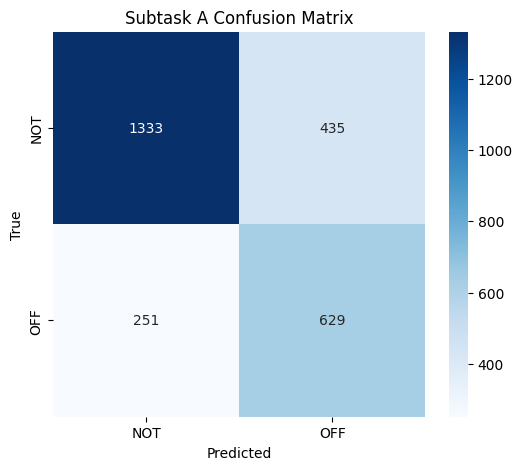

In [ ]:
print(f"\nSubtask A Best Model: {best_name_a}")
print(f"Validation Accuracy: {acc_a:.4f}")
print(classification_report(y_val_a, y_val_pred_a))
plot_confusion_matrix(y_val_a, y_val_pred_a, ['NOT', 'OFF'], "Subtask A Confusion Matrix")

In [ ]:
joblib.dump(best_est_a, 'best_model_subtask_a.pkl')
print("Subtask A model saved as 'best_model_subtask_a.pkl'")

Subtask A model saved as 'best_model_subtask_a.pkl'


In [ ]:
# Subtask B—Targeted or Untargeted?
df_b = df[df['subtask_a'] == 'OFF'].copy()
X_tfidf_b = tfidf_vectorizer.transform(df_b['clean_tweet'])
X_bert_b = get_bert_embeddings(df_b['clean_tweet'])
y_b = df_b['subtask_b']

# **Training the Models with respect to TF-IDF Features for SubTask-B**




In [ ]:
print("\n=== Subtask B: TF-IDF Models ===")
X_train_b_tfidf, X_val_b_tfidf, y_train_b, y_val_b = train_test_split(
    X_tfidf_b, y_b, test_size=0.2, random_state=42, stratify=y_b
)
best_est_b_tfidf, best_name_b_tfidf, best_score_b_tfidf, _, res_b_tfidf = train_and_compare(
    X_train_b_tfidf, y_train_b, "Subtask B"
)


=== Subtask B: TF-IDF Models ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression - Best Params: {'clf__C': 0.1}, Macro F1 (CV): 0.5938
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM - Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}, Macro F1 (CV): 0.5739
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 200}, Macro F1 (CV): 0.5825
Fitting 3 folds for each of 2 candidates, totalling 6 fits
NaiveBayes - Best Params: {'clf__alpha': 0.1}, Macro F1 (CV): 0.5056


# **Training the Models with respect to BERT Features for SubTask-B**




In [ ]:
print("\n=== Subtask B: BERT Models ===")
X_train_b_bert, X_val_b_bert, _, _ = train_test_split(
    X_bert_b, y_b, test_size=0.2, random_state=42, stratify=y_b
)
best_est_b_bert, best_name_b_bert, best_score_b_bert, is_bert_b, res_b_bert = train_and_compare(
    X_train_b_bert, y_train_b, "Subtask B", is_bert=True
)


=== Subtask B: BERT Models ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression - Best Params: {'clf__C': 0.1}, Macro F1 (CV): 0.5492
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM - Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}, Macro F1 (CV): 0.5315
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 100}, Macro F1 (CV): 0.5151


# **Predicting the Best Model Performance and Printing Results for SubTask-B**





Subtask B Best Model: LogisticRegression
Validation Accuracy: 0.7864
              precision    recall  f1-score   support

         TIN       0.91      0.84      0.87       775
         UNT       0.25      0.38      0.30       105

    accuracy                           0.79       880
   macro avg       0.58      0.61      0.59       880
weighted avg       0.83      0.79      0.81       880



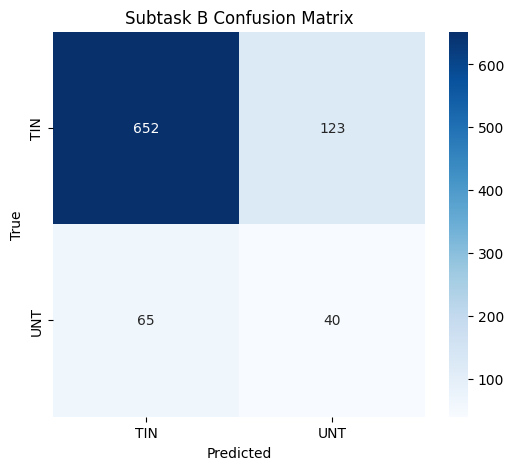

In [ ]:
best_est_b = best_est_b_bert if best_score_b_bert > best_score_b_tfidf else best_est_b_tfidf
best_name_b = f"{best_name_b_bert}_BERT" if best_score_b_bert > best_score_b_tfidf else best_name_b_tfidf
is_bert_b = best_score_b_bert > best_score_b_tfidf
y_val_pred_b = best_est_b.predict(X_val_b_bert if is_bert_b else X_val_b_tfidf)
acc_b = accuracy_score(y_val_b, y_val_pred_b)
print(f"\nSubtask B Best Model: {best_name_b}")
print(f"Validation Accuracy: {acc_b:.4f}")
print(classification_report(y_val_b, y_val_pred_b))
plot_confusion_matrix(y_val_b, y_val_pred_b, ['TIN', 'UNT'], "Subtask B Confusion Matrix")

In [ ]:
joblib.dump(best_est_b, 'best_model_subtask_b.pkl')
print("Subtask B model saved as 'best_model_subtask_b.pkl'")

Subtask B model saved as 'best_model_subtask_b.pkl'


In [ ]:
# Subtask C—Who’s the Target?
df_c = df[df['subtask_b'] == 'TIN'].copy()
X_tfidf_c = tfidf_vectorizer.transform(df_c['clean_tweet'])
X_bert_c = get_bert_embeddings(df_c['clean_tweet'])
y_c = df_c['subtask_c']

# **Training the Models with respect to TF-IDF Features for SubTask-C**




In [ ]:
print("\n=== Subtask C: TF-IDF Models ===")
X_train_c_tfidf, X_val_c_tfidf, y_train_c, y_val_c = train_test_split(
    X_tfidf_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)
best_est_c_tfidf, best_name_c_tfidf, best_score_c_tfidf, _, res_c_tfidf = train_and_compare(
    X_train_c_tfidf, y_train_c, "Subtask C"
)


=== Subtask C: TF-IDF Models ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression - Best Params: {'clf__C': 1}, Macro F1 (CV): 0.4682
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM - Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}, Macro F1 (CV): 0.4794
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 200}, Macro F1 (CV): 0.5025
Fitting 3 folds for each of 2 candidates, totalling 6 fits
NaiveBayes - Best Params: {'clf__alpha': 0.1}, Macro F1 (CV): 0.3839


# **Training the Models with respect to BERT Features for SubTask-C**




In [ ]:
print("\n=== Subtask C: BERT Models ===")
X_train_c_bert, X_val_c_bert, _, _ = train_test_split(
    X_bert_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)
best_est_c_bert, best_name_c_bert, best_score_c_bert, is_bert_c, res_c_bert = train_and_compare(
    X_train_c_bert, y_train_c, "Subtask C", is_bert=True
)


=== Subtask C: BERT Models ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression - Best Params: {'clf__C': 0.1}, Macro F1 (CV): 0.4946
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM - Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}, Macro F1 (CV): 0.4512
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 100}, Macro F1 (CV): 0.4136


# **Predicting the Best Model Performance and Printing Results for SubTask-C**





Subtask C Best Model: RandomForest
Validation Accuracy: 0.6740
              precision    recall  f1-score   support

         GRP       0.55      0.52      0.54       215
         IND       0.77      0.82      0.80       482
         OTH       0.24      0.18      0.20        79

    accuracy                           0.67       776
   macro avg       0.52      0.51      0.51       776
weighted avg       0.66      0.67      0.66       776



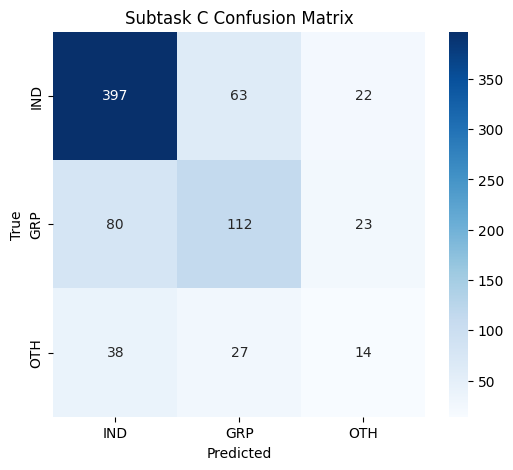

In [ ]:
best_est_c = best_est_c_bert if best_score_c_bert > best_score_c_tfidf else best_est_c_tfidf
best_name_c = f"{best_name_c_bert}_BERT" if best_score_c_bert > best_score_c_tfidf else best_name_c_tfidf
is_bert_c = best_score_c_bert > best_score_c_tfidf
y_val_pred_c = best_est_c.predict(X_val_c_bert if is_bert_c else X_val_c_tfidf)
acc_c = accuracy_score(y_val_c, y_val_pred_c)
print(f"\nSubtask C Best Model: {best_name_c}")
print(f"Validation Accuracy: {acc_c:.4f}")
print(classification_report(y_val_c, y_val_pred_c))
plot_confusion_matrix(y_val_c, y_val_pred_c, ['IND', 'GRP', 'OTH'], "Subtask C Confusion Matrix")

In [ ]:
joblib.dump(best_est_c, 'best_model_subtask_c.pkl')
print("Subtask C model saved as 'best_model_subtask_c.pkl'")

Subtask C model saved as 'best_model_subtask_c.pkl'


# **Prediction in Real Time**

In [ ]:
# Step 7: Prediction Pipeline—load and roll
best_est_a = joblib.load('best_model_subtask_a.pkl')
best_est_b = joblib.load('best_model_subtask_b.pkl')
best_est_c = joblib.load('best_model_subtask_c.pkl')

In [ ]:
def predict_olid(tweet):
    """Predict with the saved models."""
    clean_text = preprocess_tweet(tweet)
    X_tfidf_test = tfidf_vectorizer.transform([clean_text])
    X_bert_test = get_bert_embeddings([clean_text])

    pred_a = best_est_a.predict(X_bert_test if "BERT" in best_name_a else X_tfidf_test)[0]
    if pred_a == 'NOT':
        return ("NOT", None, None)

    pred_b = best_est_b.predict(X_bert_test if "BERT" in best_name_b else X_tfidf_test)[0]
    if pred_b == 'UNT':
        return ("OFF", "UNT", None)

    pred_c = best_est_c.predict(X_bert_test if "BERT" in best_name_c else X_tfidf_test)[0]
    return ("OFF", "TIN", pred_c)

In [ ]:
# Test it out
test_tweets = [
    "@USER You’re a total jerk!",
    "@USER This is fine, I guess",
    "@USER Hate this stupid group!"
]
print("\nTesting the pipeline with saved models:")
for tweet in test_tweets:
    print(f"Tweet: {tweet}")
    print(f"Prediction: {predict_olid(tweet)}\n")


Testing the pipeline with saved models:
Tweet: @USER You’re a total jerk!
Prediction: ('OFF', 'TIN', 'IND')

Tweet: @USER This is fine, I guess
Prediction: ('NOT', None, None)

Tweet: @USER Hate this stupid group!
Prediction: ('OFF', 'TIN', 'GRP')

